## Package imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta
from datetime import date
from dateutil.relativedelta import relativedelta
from collections import Counter
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from statsmodels.tsa.arima.model import ARIMA
from arch import arch_model
from statsmodels.stats.diagnostic import acorr_ljungbox

## Some auxiliar functions

In [2]:
def plot_scatter(x_Data, y_Data, x_error, y_error, x_axis_name=None, y_axis_name=None, title=None, fig_name=None, data_legend_label = "Datos experimentales"):
    #Scatter
    fig, ax = plt.subplots()
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif')
    plt.rcParams['axes.autolimit_mode'] = 'round_numbers'
    plt.errorbar(x_Data, y_Data, xerr = x_error, yerr= y_error, fmt = ".", markersize=10, c = "blue", label = data_legend_label, capsize=1, elinewidth=1)
    plt.legend(loc="best", fontsize=15)
    plt.title(title, fontsize = 30)
    plt.xlabel(x_axis_name, fontsize = 25)
    plt.ylabel(y_axis_name, fontsize = 25)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    ax.set_axisbelow(True)
    ax.grid(True, linestyle = "--")
    ax.tick_params(bottom=True, top=True, left=True, right=True)
    ax.tick_params(axis="y",direction="in")
    ax.tick_params(axis="x",direction="in")
    
    #Save & Show
    plt.tight_layout()
    fig1 = plt.gcf()
    plt.show()
    if fig_name != None:
        fig1.savefig(fig_name, format = "pdf", dpi=500)

In [3]:
def plot_multiscatter(n, Data, Data_error, data_legend_labels, x_axis_name=None, y_axis_name=None, title=None, fig_name=None):
    
    fig, ax = plt.subplots()
    plt.rcParams['axes.autolimit_mode'] = 'round_numbers'
    
    #List of colors
    Colors = ["blue", "red", "green", "magenta", "cyan", "yellow"]
    
    for k in range(0,n):
        #Data asignation
        x_Data = Data[2*k]
        y_Data = Data[2*k+1]
        x_error = Data_error[2*k]
        y_error = Data_error[2*k+1]
 
        
        #Scatter
        plt.errorbar(x_Data, y_Data, xerr = x_error, yerr= y_error, fmt = ".",markersize=10, c = Colors[k], label = data_legend_labels[k], capsize=0, elinewidth=0)
        if y_error is not None and not y_error.empty:
            plt.fill_between(x_Data, y_Data - y_error, y_Data + y_error, alpha=0.2, color="red")
    
    #Scatter
    plt.legend(loc="upper left", fontsize = 12)
    plt.title(title, fontsize = 20)
    plt.xlabel(x_axis_name, fontsize = 15)
    plt.ylabel(y_axis_name, fontsize = 15)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    ax.set_axisbelow(True)
    ax.tick_params(bottom=True, top=False, left=True, right=False)
    ax.tick_params(axis="y",direction="out")
    ax.tick_params(axis="x",direction="out")
    plt.gca().xaxis.set_major_locator(mdates.YearLocator())
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))


    # Rotar las etiquetas para una mejor visualización
    plt.xticks(rotation=45)

     
    #Save & Show
    plt.tight_layout()
    fig1 = plt.gcf()
    plt.show()
    if fig_name != None:
        fig1.savefig(fig_name, format = "pdf", dpi=500)

## 1. Data load

Comenzamos cargando el conjunto de datos que se nos ha proporcionado para el reto.

In [4]:
raw_df = pd.read_csv('Data.csv')

## 2. Data visualization

Realizamos un primer estudio superficial del conjunto de datos y sus variables.

In [5]:
raw_df.head(10)

,CODIGO,FECHAPEDIDO,NUMERO,REFERENCIA,CANTIDADCOMPRA,UNIDADESCONSUMOCONTENIDAS,PRECIO,IMPORTELINEA,TIPOCOMPRA,ORIGEN,TGL,PRODUCTO
0,E99808,01/01/23,1595724/23,178567.1,60,10,62.590000,375.540000,Compra menor,1-2-60,TRANSITO,APOSITO DE FIBRAS DE POLIACRILATO C/PLATA-3
1,B41691,01/02/16,72714/16,400403,40,10,102.803729,411.214916,Compra menor,0-10-1,ALMACENABLE,SOLUCION P/ LIMPIEZA Y DESCONTAMINACION DE HER...
2,E64543,01/02/16,71961/16,403770,20,5,12.100000,48.400000,Compra menor,0-4-111,TRANSITO,APOSITO DE HIDROFIBRA / CINTA-18
3,E65007,01/02/16,72773/16,20415,100,50,215.325000,430.650000,Concurso,0-10-1,ALMACENABLE,APOSITO DE ESPUMA POLIURETANO / SACRO-11
4,E64911,01/02/17,86159/17,20701,300,300,792.000000,792.000000,Concurso,0-6-1,ALMACENABLE,APOSITO C/ CARBON Y PLATA-6
5,E65509,01/02/17,86264/17,161445.2,80,10,53.888999,431.111992,Concurso,0-0-2,ALMACENABLE,APOSITO DE FIBRAS DE POLIACRILATO-3
6,E65894,01/02/17,86265/17,157028.4,140,10,35.189001,492.646014,Concurso,0-6-1,ALMACENABLE,APOSITO MALLADO C/ PARAFINA-39
7,E66071,01/02/17,86147/17,420680,600,10,20.900000,1254.000000,Compra menor,0-13-1,ALMACENABLE,APOSITO DE HIDROFIBRA DE HIDROCOLOIDE C/ ESPUM...
8,E64543,01/02/18,91119/18,403770,40,5,12.100000,96.800000,Compra menor,0-11-153,TRANSITO,APOSITO DE HIDROFIBRA / CINTA-18
9,E64663,01/02/18,92073/18,413568,100,100,539.005500,539.005500,Concurso,0-0-2,ALMACENABLE,APOSITO DE HIDROFIBRA DE HIDROCOLOIDE C/ PLATA-3


In [6]:
raw_df.describe()

,CANTIDADCOMPRA,UNIDADESCONSUMOCONTENIDAS,PRECIO,IMPORTELINEA
count,15698.000000,15698.000000,15698.000000,15698.000000
mean,369.235062,83.185820,122.893353,569.473009
std,758.202692,195.915475,221.454340,748.721488
min,1.000000,1.000000,0.989571,0.000000
25%,40.000000,5.000000,13.959000,121.000000
50%,120.000000,10.000000,44.000000,322.080000
75%,330.000000,50.000000,102.802000,719.949286
max,10000.000000,2000.000000,2458.500000,11439.928600


In [7]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15698 entries, 0 to 15697
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   CODIGO                     15698 non-null  object 
 1   FECHAPEDIDO                15698 non-null  object 
 2   NUMERO                     15698 non-null  object 
 3   REFERENCIA                 15698 non-null  object 
 4   CANTIDADCOMPRA             15698 non-null  int64  
 5   UNIDADESCONSUMOCONTENIDAS  15698 non-null  int64  
 6   PRECIO                     15698 non-null  float64
 7   IMPORTELINEA               15698 non-null  float64
 8   TIPOCOMPRA                 15698 non-null  object 
 9   ORIGEN                     15698 non-null  object 
 10  TGL                        15595 non-null  object 
 11  PRODUCTO                   15698 non-null  object 
dtypes: float64(2), int64(2), object(8)
memory usage: 1.4+ MB


Estudiamos las diferentes variables objeto:

#### CÓDIGO

In [8]:
Lista_codigos = raw_df["CODIGO"].unique()
Lista_codigos

array(['E99808', 'B41691', 'E64543', 'E65007', 'E64911', 'E65509',
       'E65894', 'E66071', 'E64663', 'E64898', 'E65056', 'E70130',
       'E64761', 'E64946', 'E64764', 'E64765', 'E64932', 'E64983',
       'E67462', 'E69682', 'E78950', 'E99807', 'B40558', 'F43580',
       'F50071', 'E64544', 'E85758', 'F43325', 'F44200', 'E64940',
       'E73753', 'E65159', 'E65485', 'F43581', 'F43585', 'F42922',
       'E64751', 'E65201', 'F46846', 'E65486', 'E64488', 'E85769',
       'C26183', 'E64750', 'E67835', 'F46843', 'C56207', 'F43331'],
      dtype=object)

In [9]:
len(raw_df["CODIGO"].unique())

48

In [10]:
raw_df["CODIGO"].value_counts()

CODIGO
B41691    925
E64543    924
E66071    898
E64663    757
E99808    632
E65056    632
E64983    597
E64932    586
E78950    565
E99807    542
B40558    524
E64751    509
E64911    431
E64544    417
E64764    413
E64946    389
E85758    365
E73753    345
E64750    341
F43580    336
E65485    316
E70130    314
E65509    309
E64488    303
E64765    290
E65159    271
E69682    261
E65894    261
F43581    252
E65486    244
E65007    231
E85769    190
E64940    149
E64761    127
F44200    126
E64898    110
F43585    109
E67462    103
E67835     98
E65201     82
F42922     79
F46846     70
F50071     66
F43325     63
C26183     50
C56207     44
F46843     27
F43331     25
Name: count, dtype: int64

#### PRODUCTO

In [11]:
raw_df["PRODUCTO"].unique()

array(['APOSITO DE FIBRAS DE POLIACRILATO C/PLATA-3',
       'SOLUCION P/ LIMPIEZA Y DESCONTAMINACION DE HERIDAS-16',
       'APOSITO DE HIDROFIBRA  / CINTA-18',
       'APOSITO DE ESPUMA POLIURETANO / SACRO-11',
       'APOSITO C/ CARBON Y PLATA-6',
       'APOSITO DE FIBRAS DE POLIACRILATO-3',
       'APOSITO MALLADO C/ PARAFINA-39',
       'APOSITO DE HIDROFIBRA DE HIDROCOLOIDE C/ ESPUMA POLIURETANO-12',
       'APOSITO DE HIDROFIBRA DE HIDROCOLOIDE C/ PLATA-3',
       'APÓSITO ADHESIVO ABSORBENTE IMPERMEABLE C/ BOLSA-21',
       'APOSITO DE HIDROCOLOIDE-9', 'APOSITO DE HIDROCOLOIDE-7',
       'APOSITO DE HIDROCOLOIDE C/ PLATA-2',
       'APOSITO DE ESPUMA POLIURETANO-8',
       'APÓSITO ABSORBENTE C/ ADHESIVO-22',
       'APÓSITO ABSORBENTE C/ ADHESIVO-23', 'HIDROGEL-37',
       'APOSITO MALLADO C/ PARAFINA-38',
       'APOSITO DE HIDROCOLOIDE C/ PLATA-5',
       'APÓSITO MALLADO C/ OLIGOSACÁRIDOS-1',
       'ELIMINADOR DE ADHESIVOS MEDICOS DE LA PIEL-17',
       'APOSITO DE FIBRAS

In [12]:
len(raw_df["PRODUCTO"].unique())

48

In [13]:
raw_df["PRODUCTO"].value_counts()

PRODUCTO
SOLUCION P/ LIMPIEZA Y DESCONTAMINACION DE HERIDAS-16                                925
APOSITO DE HIDROFIBRA  / CINTA-18                                                    924
APOSITO DE HIDROFIBRA DE HIDROCOLOIDE C/ ESPUMA POLIURETANO-12                       898
APOSITO DE HIDROFIBRA DE HIDROCOLOIDE C/ PLATA-3                                     757
APOSITO DE FIBRAS DE POLIACRILATO C/PLATA-3                                          632
APOSITO DE HIDROCOLOIDE-9                                                            632
APOSITO MALLADO C/ PARAFINA-38                                                       597
HIDROGEL-37                                                                          586
ELIMINADOR DE ADHESIVOS MEDICOS DE LA PIEL-17                                        565
APOSITO DE FIBRAS DE POLIACRILATO C/PLATA-6                                          542
GEL P/ LIMPIEZA  Y DESCONTAMINACION DE HERIDAS-15                                    524
APÓSITO TRAN

Vemos que codigo y producto son lo mismo.

#### Referencias

In [14]:
raw_df["REFERENCIA"].unique()

array(['178567.1', '400403', '403770', '20415', '20701', '161445.2',
       '157028.4', '420680', '413568', '0037447', '33533', '187662',
       '265868.4', '66800248', '1383', '1385', '7311', '157027.7',
       '152026.5', '166680.2', 'TR101', '178565.7', '400505',
       'M8275051/5', '421554', '420621', '33436', '409761', '421551',
       '291010', '3533', 'MAP190', '39001', '281 421', '33115', '34100',
       '409729', '409726', 'M8275098/5', '409721', '31150', '155486.4',
       '1624W', '3760', '66802003', '37147', '31100', '4628',
       'M8275096/10', '284300', '33110', '33435', '1494.00', '507633',
       '4630', '37167', '423289', 'M8275052/5', '0037167', '66974941',
       '66802004', '1492.00', '1626W', 'M8275052/10', 'M8275096/5',
       'ULTVFL05MD', '370605', 'ABT1055', '1001'], dtype=object)

In [15]:
len(raw_df["REFERENCIA"].unique())

69

In [16]:
raw_df["REFERENCIA"].value_counts()

REFERENCIA
400403        925
403770        924
420680        898
413568        757
178567.1      632
             ... 
ULTVFL05MD     25
ABT1055        23
370605          5
M8275096/5      3
1001            1
Name: count, Length: 69, dtype: int64

In [17]:
raw_df[raw_df["REFERENCIA"] == "1001"]

,CODIGO,FECHAPEDIDO,NUMERO,REFERENCIA,CANTIDADCOMPRA,UNIDADESCONSUMOCONTENIDAS,PRECIO,IMPORTELINEA,TIPOCOMPRA,ORIGEN,TGL,PRODUCTO
4814,B40558,10/07/23,843973/23,1001,40,20,163.9,327.8,Compra menor,0-7-87,TRANSITO,GEL P/ LIMPIEZA Y DESCONTAMINACION DE HERIDAS-15


Vemos que "referencia" nos aporta una información similar que "código". Por ello, decidimos quedarnos con esta última, pues proporciona una descripción más precisa del producto que se compra.

#### Cantidad compra

In [18]:
raw_df[raw_df["CODIGO"] == "B40558"]["CANTIDADCOMPRA"].value_counts()

CANTIDADCOMPRA
10     169
2      119
5       79
4       78
6       29
7       16
1       13
8        9
60       3
3        2
30       2
50       2
100      1
40       1
12       1
Name: count, dtype: int64

Vemos que "Cantidad compra" no sigue, a priori, nigún patrón en concreto.

#### Tipo compra

In [19]:
raw_df["TIPOCOMPRA"].unique()

array(['Compra menor', 'Concurso'], dtype=object)

In [20]:
raw_df["TIPOCOMPRA"].value_counts()

TIPOCOMPRA
Compra menor    9745
Concurso        5953
Name: count, dtype: int64

Vemos que "Tipo compra" solo toma dos valores, lo que nos llevará a codificarla con 0s y 1s.

#### Origen

In [21]:
origenes = raw_df["ORIGEN"].unique()
origenes

array(['1-2-60', '0-10-1', '0-4-111', '0-6-1', '0-0-2', '0-13-1',
       '0-11-153', '0-6-95', '0-0-37', '0-18-1', '0-18-178', '0-4-1',
       '0-12-146', '0-12-101', '0-18-71', '0-14-50', '0-11-151',
       '0-11-136', '0-12-80', '0-15-16', '0-11-113', '0-0-13', '0-0-51',
       '0-14-23', '0-18-108', '0-11-112', '0-12-123', '0-11-168',
       '0-10-163', '0-4-129', '0-18-173', '0-6-76', '0-15-15', '0-17-162',
       '1-2-59', '0-11-118', '0-12-154', '0-10-155', '0-7-11', '0-9-74',
       '0-8--1', '0-10-117', '0-14-44', '0-18-61', '0-12-100', '0-18-62',
       '0-14-12', '0-7-3', '0-14-25', '0-14-33', '0-14-49', '0-18-105',
       '0-3-186', '0-18-172', '0-7-10', '0-6-148', '0-14-20', '0-15-27',
       '0-7-85', '0-5-14', '0-5-46', '0-18-81', '0-11-67', '0-12-119',
       '0-12-135', '0-10-149', '0-12-66', '0-15-58', '0-18-109',
       '0-11-110', '0-12-143', '0-0-52', '0-12-142', '0-7-8', '0-4-187',
       '0-18-97', '0-1-150', '0-1-111', '0-5-39', '0-12-82', '0-18-174',
       '0-1

In [22]:
ultimos_numeros = [int(item.split('-')[1]) for item in origenes]
conteo_ultimos_numeros = Counter(ultimos_numeros)
conteo_ultimos_numeros

Counter({2: 9,
         10: 14,
         4: 11,
         6: 12,
         0: 10,
         13: 2,
         11: 25,
         18: 20,
         12: 24,
         14: 31,
         15: 8,
         17: 1,
         7: 21,
         9: 1,
         8: 1,
         3: 2,
         5: 4,
         1: 4,
         19: 1,
         16: 1})

In [23]:
len(raw_df["ORIGEN"].unique())

202

Más adelante obtendremos, a partir de esta varaible, la región en la que se encuentra el hospital y un identificador del propio hospital. Descartaremos la tercera parte de la variable que hace referencia al departamento en el que se lleva a cabo la compra.

#### TGL

In [24]:
raw_df["TGL"].unique()

array(['TRANSITO', 'ALMACENABLE', nan], dtype=object)

In [25]:
raw_df["TGL"].value_counts()

TGL
ALMACENABLE    11560
TRANSITO        4035
Name: count, dtype: int64

Vemos que "TGL" solo toma dos valores, lo que nos llevará a codificarla con 0s y 1s.

## 3. First data processing

Tras haber hecho un estudio superficial de las características, comenzamos a trabajar con ellas; ya sea codificandolas a valores númericos, creando variables nuevas o eliminando aquellas que no consideremos útiles.

In [26]:
df_1 = raw_df

#AÑADIMOS NUEVAS VARIABLES A PARTIR DE ANTIGUAS
df_1['PRECIOUNIDAD']=df_1['IMPORTELINEA']/df_1['CANTIDADCOMPRA'] #Nos indica el precio por unidad
df_1['LETRACODIGO']=df_1['CODIGO'].str[:1] #Obtenemos la letra de la variable codigo
df_1['REGION']=df_1['ORIGEN'].str.split(pat="-", n=-1, expand=False).str[0] #Obtenemos la región del hospital
df_1['HOSPITAL']=df_1['ORIGEN'].str.split(pat="-", n=-1, expand=False).str[1] #Obtenemos el identificador del hospital.

#ELIMINAMOS LAS FILAS QUE TIENEN UN NAN EN TGL
df_1 = df_1.dropna(subset=['TGL']) 
df_1 = df_1.reset_index(drop=True)

#ELIMINAMOS LAS COLUMNAS DE DATOS SUPERFLUOS
df_1 = df_1.drop(columns=['PRODUCTO', 'REFERENCIA','ORIGEN', 'NUMERO'])

#ASIGNAMOS A LAS VARIABLES TGL Y TIPOCOMPRA UN NUMERO BINARIO
df_1['TGL'] = pd.factorize(df_1['TGL'], sort=True)[0] #TRANSITO = 1, ALMACENABLE = 0
df_1['TIPOCOMPRA'] = pd.factorize(df_1['TIPOCOMPRA'], sort=True)[0] #CONCURSO = 1, COMPRA MENOR = 0 

In [27]:
df_1.head(10)

,CODIGO,FECHAPEDIDO,CANTIDADCOMPRA,UNIDADESCONSUMOCONTENIDAS,PRECIO,IMPORTELINEA,TIPOCOMPRA,TGL,PRECIOUNIDAD,LETRACODIGO,REGION,HOSPITAL
0,E99808,01/01/23,60,10,62.590000,375.540000,0,1,6.259000,E,1,2
1,B41691,01/02/16,40,10,102.803729,411.214916,0,0,10.280373,B,0,10
2,E64543,01/02/16,20,5,12.100000,48.400000,0,1,2.420000,E,0,4
3,E65007,01/02/16,100,50,215.325000,430.650000,1,0,4.306500,E,0,10
4,E64911,01/02/17,300,300,792.000000,792.000000,1,0,2.640000,E,0,6
5,E65509,01/02/17,80,10,53.888999,431.111992,1,0,5.388900,E,0,0
6,E65894,01/02/17,140,10,35.189001,492.646014,1,0,3.518900,E,0,6
7,E66071,01/02/17,600,10,20.900000,1254.000000,0,0,2.090000,E,0,13
8,E64543,01/02/18,40,5,12.100000,96.800000,0,1,2.420000,E,0,11
9,E64663,01/02/18,100,100,539.005500,539.005500,1,0,5.390055,E,0,0


A continuación, creamos la variable duracion unidad, que definimos como CantidadCompra/DiasSiguienteCompra. La nueva variable DuracionUnidad nos cuantas unidades de un cierto producto consumimos por día.

In [28]:
df_1["FECHAPEDIDO"] = pd.to_datetime(df_1["FECHAPEDIDO"], format = '%d/%m/%y')
df_1["TIEMPOENTRECOMPRAS"] = ""
df_1["DURACIONUNIDAD"] = ""
df_1.head(10)

,CODIGO,FECHAPEDIDO,CANTIDADCOMPRA,UNIDADESCONSUMOCONTENIDAS,PRECIO,IMPORTELINEA,TIPOCOMPRA,TGL,PRECIOUNIDAD,LETRACODIGO,REGION,HOSPITAL,TIEMPOENTRECOMPRAS,DURACIONUNIDAD
0,E99808,2023-01-01,60,10,62.590000,375.540000,0,1,6.259000,E,1,2,,
1,B41691,2016-02-01,40,10,102.803729,411.214916,0,0,10.280373,B,0,10,,
2,E64543,2016-02-01,20,5,12.100000,48.400000,0,1,2.420000,E,0,4,,
3,E65007,2016-02-01,100,50,215.325000,430.650000,1,0,4.306500,E,0,10,,
4,E64911,2017-02-01,300,300,792.000000,792.000000,1,0,2.640000,E,0,6,,
5,E65509,2017-02-01,80,10,53.888999,431.111992,1,0,5.388900,E,0,0,,
6,E65894,2017-02-01,140,10,35.189001,492.646014,1,0,3.518900,E,0,6,,
7,E66071,2017-02-01,600,10,20.900000,1254.000000,0,0,2.090000,E,0,13,,
8,E64543,2018-02-01,40,5,12.100000,96.800000,0,1,2.420000,E,0,11,,
9,E64663,2018-02-01,100,100,539.005500,539.005500,1,0,5.390055,E,0,0,,


Fijamos un codigo de producto y un hospital.

In [29]:
# Fijamos codigo y hospital
Lista_codigo = df_1["CODIGO"].unique()
codigo_fijado = "B41691"
hospital_fijado = "18"

df_codigo_hospital = df_1[(df_1["CODIGO"] == codigo_fijado) & (df_1["HOSPITAL"] == hospital_fijado)]
fecha_codigo_hospital = df_codigo_hospital["FECHAPEDIDO"]
fecha_codigo_hospital_ordenada = np.sort(fecha_codigo_hospital)

diferencias_en_dias = np.diff(fecha_codigo_hospital_ordenada).astype('timedelta64[D]').astype(int)

for i in range(0,len(diferencias_en_dias)):
    fecha_i = fecha_codigo_hospital_ordenada[i]
    dias_i = diferencias_en_dias[i]
    unidades_i = df_codigo_hospital[df_codigo_hospital["FECHAPEDIDO"] == fecha_i]["CANTIDADCOMPRA"]
    df_codigo_hospital.loc[df_codigo_hospital["FECHAPEDIDO"] == fecha_i, "DURACIONUNIDAD"] = unidades_i/dias_i

df_codigo_hospital.head(10)

,CODIGO,FECHAPEDIDO,CANTIDADCOMPRA,UNIDADESCONSUMOCONTENIDAS,PRECIO,IMPORTELINEA,TIPOCOMPRA,TGL,PRECIOUNIDAD,LETRACODIGO,REGION,HOSPITAL,TIEMPOENTRECOMPRAS,DURACIONUNIDAD
208,B41691,2021-07-01,70,10,107.250000,750.750000,0,0,10.725000,B,0,18,,5.384615
349,B41691,2021-10-01,70,10,107.250000,750.750000,0,0,10.725000,B,0,18,,10.0
366,B41691,2020-12-01,90,10,102.802000,925.218000,0,0,10.280200,B,0,18,,6.428571
392,B41691,2022-12-01,160,10,134.431000,2150.896000,0,0,13.443100,B,0,18,,12.307692
425,B41691,2016-02-02,60,10,102.803729,616.822374,0,0,10.280373,B,0,18,,4.615385
638,B41691,2020-07-02,80,10,102.802000,822.416000,0,0,10.280200,B,0,18,,7.272727
751,B41691,2015-10-02,20,10,102.803729,205.607458,0,0,10.280373,B,0,18,,2.857143
1127,B41691,2019-06-03,90,10,102.802000,925.218000,0,0,10.280200,B,0,18,,9.0
1223,B41691,2018-08-03,70,10,102.802000,719.614000,0,0,10.280200,B,0,18,,3.684211
1393,B41691,2019-12-03,60,10,102.802000,616.812000,0,0,10.280200,B,0,18,,6.0


Mediante un par de bucles for, calculamos esta variable para el resto de productos y hospitales.

In [30]:
Lista_codigo = df_1["CODIGO"].unique()
Lista_hospital = df_1["HOSPITAL"].unique()

niter = 0

for hospital_fijado in Lista_hospital:
    for codigo_fijado in Lista_codigo:
        #Hacemos un nuevo dataframe fijando hospital y codigo para obtener y ordenar fechas
        df_codigo_hospital = df_1[(df_1["CODIGO"] == codigo_fijado) & (df_1["HOSPITAL"] == hospital_fijado)]
        fecha_codigo_hospital = df_codigo_hospital["FECHAPEDIDO"]
        fecha_codigo_hospital_ordenada = np.sort(fecha_codigo_hospital)
        diferencias_en_dias = np.diff(fecha_codigo_hospital_ordenada).astype('timedelta64[D]').astype(int)
        
        for i in range(0,len(diferencias_en_dias)):
            niter += 1
            if (niter%1000 == 0):
                print(niter)
            fecha_i = fecha_codigo_hospital_ordenada[i]
            dias_i = diferencias_en_dias[i]
            unidades_i = df_codigo_hospital[df_codigo_hospital["FECHAPEDIDO"] == fecha_i]["CANTIDADCOMPRA"]
            df_1.loc[(df_1["CODIGO"] == codigo_fijado) & (df_1["HOSPITAL"] == hospital_fijado) & (df_1["FECHAPEDIDO"] == fecha_i), "TIEMPOENTRECOMPRAS"] = dias_i
            df_1.loc[(df_1["CODIGO"] == codigo_fijado) & (df_1["HOSPITAL"] == hospital_fijado) & (df_1["FECHAPEDIDO"] == fecha_i), "DURACIONUNIDAD"] = unidades_i/dias_i

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000


In [31]:
df_1.head(10)

,CODIGO,FECHAPEDIDO,CANTIDADCOMPRA,UNIDADESCONSUMOCONTENIDAS,PRECIO,IMPORTELINEA,TIPOCOMPRA,TGL,PRECIOUNIDAD,LETRACODIGO,REGION,HOSPITAL,TIEMPOENTRECOMPRAS,DURACIONUNIDAD
0,E99808,2023-01-01,60,10,62.590000,375.540000,0,1,6.259000,E,1,2,,
1,B41691,2016-02-01,40,10,102.803729,411.214916,0,0,10.280373,B,0,10,11,3.636364
2,E64543,2016-02-01,20,5,12.100000,48.400000,0,1,2.420000,E,0,4,7,2.857143
3,E65007,2016-02-01,100,50,215.325000,430.650000,1,0,4.306500,E,0,10,35,2.857143
4,E64911,2017-02-01,300,300,792.000000,792.000000,1,0,2.640000,E,0,6,22,13.636364
5,E65509,2017-02-01,80,10,53.888999,431.111992,1,0,5.388900,E,0,0,7,11.428571
6,E65894,2017-02-01,140,10,35.189001,492.646014,1,0,3.518900,E,0,6,8,17.5
7,E66071,2017-02-01,600,10,20.900000,1254.000000,0,0,2.090000,E,0,13,13,46.153846
8,E64543,2018-02-01,40,5,12.100000,96.800000,0,1,2.420000,E,0,11,7,5.714286
9,E64663,2018-02-01,100,100,539.005500,539.005500,1,0,5.390055,E,0,0,8,12.5


In [32]:
Columnas_ordenadas = ["REGION", "HOSPITAL", "LETRACODIGO", "CODIGO", "FECHAPEDIDO", "TIPOCOMPRA", "TGL", "UNIDADESCONSUMOCONTENIDAS", "PRECIO", "CANTIDADCOMPRA", "PRECIOUNIDAD", "DURACIONUNIDAD", "TIEMPOENTRECOMPRAS", "IMPORTELINEA"]

In [33]:
df_1_ordenado = df_1[Columnas_ordenadas]
df_1_ordenado.head(10)

,REGION,HOSPITAL,LETRACODIGO,CODIGO,FECHAPEDIDO,TIPOCOMPRA,TGL,UNIDADESCONSUMOCONTENIDAS,PRECIO,CANTIDADCOMPRA,PRECIOUNIDAD,DURACIONUNIDAD,TIEMPOENTRECOMPRAS,IMPORTELINEA
0,1,2,E,E99808,2023-01-01,0,1,10,62.590000,60,6.259000,,,375.540000
1,0,10,B,B41691,2016-02-01,0,0,10,102.803729,40,10.280373,3.636364,11,411.214916
2,0,4,E,E64543,2016-02-01,0,1,5,12.100000,20,2.420000,2.857143,7,48.400000
3,0,10,E,E65007,2016-02-01,1,0,50,215.325000,100,4.306500,2.857143,35,430.650000
4,0,6,E,E64911,2017-02-01,1,0,300,792.000000,300,2.640000,13.636364,22,792.000000
5,0,0,E,E65509,2017-02-01,1,0,10,53.888999,80,5.388900,11.428571,7,431.111992
6,0,6,E,E65894,2017-02-01,1,0,10,35.189001,140,3.518900,17.5,8,492.646014
7,0,13,E,E66071,2017-02-01,0,0,10,20.900000,600,2.090000,46.153846,13,1254.000000
8,0,11,E,E64543,2018-02-01,0,1,5,12.100000,40,2.420000,5.714286,7,96.800000
9,0,0,E,E64663,2018-02-01,1,0,100,539.005500,100,5.390055,12.5,8,539.005500


In [34]:
df_1_ordenado.to_csv('Data1.csv', index=False)

Finalmente, tras intentar modelizar el número DuracionUnidad para cada producto y hospital sin éxito, realizamos un nuevo procesamiento de datos definiendo una nueva variable que nos será más útil.

## 4. Second data processing

In [35]:
df_2 = pd.read_csv('Data1.csv')

In [36]:
df_2["FECHAPEDIDO"] = pd.to_datetime(df_2["FECHAPEDIDO"], format = '%Y-%m-%d')
df_2 = df_2.sort_values(by='FECHAPEDIDO')

In [37]:
df_2

,REGION,HOSPITAL,LETRACODIGO,CODIGO,FECHAPEDIDO,TIPOCOMPRA,TGL,UNIDADESCONSUMOCONTENIDAS,PRECIO,CANTIDADCOMPRA,PRECIOUNIDAD,DURACIONUNIDAD,TIEMPOENTRECOMPRAS,IMPORTELINEA
408,0,0,E,E64751,2015-01-02,0,0,400,58.800000,800,0.147000,33.333333,24.0,117.60000
407,0,0,E,E64663,2015-01-02,0,0,5,29.150000,100,5.830000,5.882353,17.0,583.00000
409,0,0,E,E66071,2015-01-02,0,0,10,20.900000,100,2.090000,4.761905,21.0,209.00000
406,0,0,B,B41691,2015-01-02,0,0,10,102.803729,100,10.280373,1.190476,84.0,1028.03729
1972,0,10,E,E66071,2015-01-05,0,0,10,20.900000,160,2.090000,7.619048,21.0,334.40000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
823,0,11,F,F46846,2023-11-02,0,1,1,154.000000,2,154.000000,NaN,NaN,308.00000
820,0,11,E,E64543,2023-11-02,0,1,5,12.100000,5,2.420000,NaN,NaN,12.10000
821,0,12,E,E78950,2023-11-02,0,1,12,77.880000,12,6.490000,NaN,NaN,77.88000
822,0,15,E,E99808,2023-11-02,0,1,10,62.590000,50,6.259000,NaN,NaN,312.95000


Calcularemos ahora, fijado un producto, el número de compras que se hacen de éste en un mes para todos los hospitales de la región 0.

In [38]:
Lista_codigo = df_2["CODIGO"].unique()
Lista_hospital = df_2["HOSPITAL"].unique()

#FIJAMOS CODIGO
codigo_fijado = "B41691"

#Creamos nuevas columnas de nuestro DataFrame.
mensual_hospital_codigo = pd.DataFrame()
mensual_hospital_codigo["MES"] = ""
MES = []
mensual_hospital_codigo["NUMEROCOMPRAS"] = ""
NUMEROCOMPRAS = []

#Calculamos las compras mensuales de un producto fijado.
df_hospital_codigo = df_2[(df_2["CODIGO"] == codigo_fijado) & (df_2["REGION"] == 0)]

fechas_hospital_codigo = df_hospital_codigo["FECHAPEDIDO"]
fechas_hospital_codigo = fechas_hospital_codigo.dt.strftime('%Y-%m').unique()
fechas_hospital_codigo = np.delete(fechas_hospital_codigo,0)
fechas_hospital_codigo = np.delete(fechas_hospital_codigo,len(fechas_hospital_codigo)-1)

for fecha_i in fechas_hospital_codigo:
    MES.append(fecha_i)
    NUMEROCOMPRAS.append(sum(df_hospital_codigo[df_hospital_codigo["FECHAPEDIDO"].dt.strftime('%Y-%m') == fecha_i]["CANTIDADCOMPRA"]))
    
mensual_hospital_codigo["MES"] = MES
mensual_hospital_codigo["MES"] = pd.to_datetime(mensual_hospital_codigo["MES"], format = '%Y-%m')
mensual_hospital_codigo["NUMEROCOMPRAS"] = NUMEROCOMPRAS

mensual_hospital_codigo = mensual_hospital_codigo.dropna(subset=['NUMEROCOMPRAS']) 
mensual_hospital_codigo = mensual_hospital_codigo.reset_index(drop=True) 
mensual_hospital_codigo = mensual_hospital_codigo[mensual_hospital_codigo["MES"].dt.strftime('%Y') != "2023"] #Eliminamos los datos de 2023, que interpretaremos como un especie de "Test set"

mensual_hospital_codigo.tail(10)

,MES,NUMEROCOMPRAS
85,2022-03-01,1170
86,2022-04-01,950
87,2022-05-01,1180
88,2022-06-01,1580
89,2022-07-01,1840
90,2022-08-01,1470
91,2022-09-01,1400
92,2022-10-01,1540
93,2022-11-01,880
94,2022-12-01,1790


Ploteamos la serie temporal obtenido, para ver si podemos inferir algun tipo de patrón.

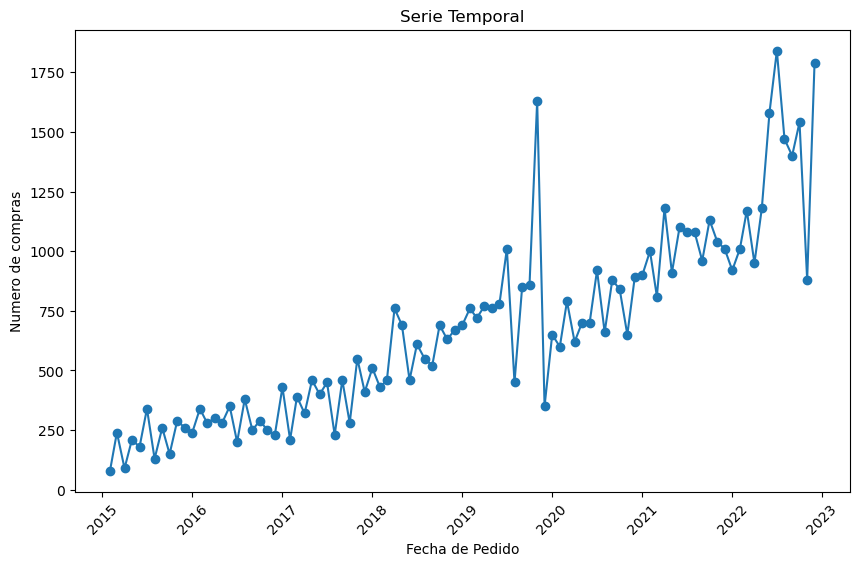

In [39]:
plot_df = mensual_hospital_codigo
plot_df = plot_df.dropna(subset=['NUMEROCOMPRAS']) 
plot_df = plot_df.reset_index(drop=True)

plt.figure(figsize=(10, 6))
plt.plot(plot_df['MES'], plot_df['NUMEROCOMPRAS'], marker='o', linestyle='-')

plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.xlabel('Fecha de Pedido')
plt.ylabel('Numero de compras')
plt.title('Serie Temporal')

plt.xticks(rotation=45)

plt.show()

A continuación diferenciamos la serie y la ajustamos a modelos del tipo ARMA(p,q)/GARCH(P,Q).

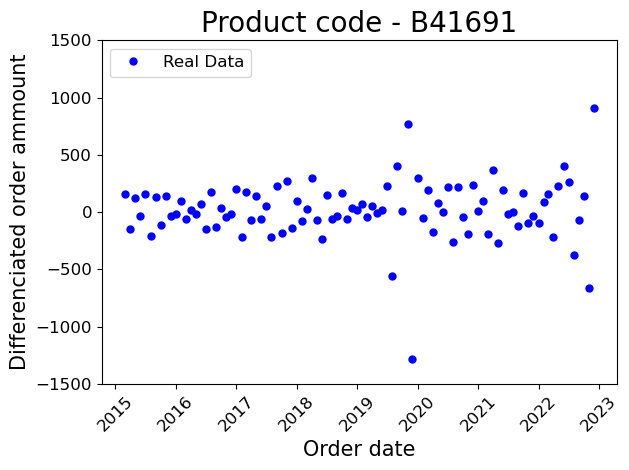

C:\Users\marti\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\marti\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Mi modelo es un ARMA (1, 0, 2) /GARCH (2, 2)

La predicción es:
Mes  0 --> 1317.0265092469429 +- 536.7802325931294
Mes  1 --> 1535.505916195297 +- 678.8891451499493
Mes  2 --> 1379.7460178841854 +- 469.8689647532504
Mes  3 --> 1533.5094494086766 +- 409.550915451244
Mes  4 --> 1431.2744051822133 +- 489.36502630736663
Mes  5 --> 1540.7688600588378 +- 350.2106178527808
Mes  6 --> 1475.1475035661156 +- 300.1961152998977
Mes  7 --> 1554.3597556232066 +- 354.5743523226666
Mes  8 --> 1513.783999952559 +- 255.10255347436893
Mes  9 --> 1572.2817047794838 +- 224.28967176928035
Mes  10 --> 1548.8383976373857 +- 255.3439208516114
Mes  11 --> 1593.1663120594326 +- 191.53816447257628


In [40]:
#Difrenciamos la serie temporal y la representamos.
df = mensual_hospital_codigo
df['diferenciada'] = df['NUMEROCOMPRAS'].diff()
df = df.dropna(subset=['diferenciada']) 
df = df.reset_index(drop=True) # Resetting the indices using df.reset_index()

plot_multiscatter(1,[df["MES"],df["diferenciada"]],[None,None],["Real Data"],"Order date","Differenciated order ammount","Product code - "+codigo_fijado)

# Ajustamos un modelo ARMA(p,q) - Nos quedamos con el modelo con el menor AIC.
p_posibles = [0,1,2]
q_posibles = [0,1,2]
AIC_min = 10**6
p_buena = 0
q_buena = 0

for p in p_posibles:
    for q in q_posibles:
        if p+q>0:
            order_arima = (p, 0, q)
            model_arima = ARIMA(df['diferenciada'], order = order_arima)
            results_arima = model_arima.fit()
            if results_arima.aic < AIC_min:
                AIC_min = results_arima.aic
                p_buena = p
                q_buena = q
                
order_arima = (p_buena, 0, q_buena) 
model_arima = ARIMA(df['diferenciada'], order=order_arima)
results_arima = model_arima.fit()

#Calculamos sus residuos
residuals = results_arima.resid

# Ajustar un modelo GARCH(P,Q) a los residuos - Nos quedamos con el modelo con el menor AIC.
P_posibles = [1,2]
Q_posibles = [0,1,2]
AIC_min = 10**6
P_buena = 0
Q_buena = 0

for P in P_posibles:
    for Q in Q_posibles:
        if P+Q>0:
            order_garch = (P, Q)
            model_garch = arch_model(residuals, vol='Garch', p=order_garch[0], q=order_garch[1],rescale=False)
            results_garch = model_garch.fit(disp=False)
            if results_garch.aic < AIC_min:
                AIC_min = results_arima.aic
                P_buena = P
                Q_buena = Q

order_garch = (P_buena, Q_buena) 
model_garch = arch_model(residuals, vol='Garch', p=order_garch[0], q=order_garch[1],rescale=False)
results_garch = model_garch.fit(disp=False)


#Resultado final
print("Mi modelo es un ARMA",order_arima,"/GARCH",order_garch)

#Comprobamos si este modelo se ajusta correctamente, i.e., estudiamos la correlación entre sus residuos estandarizados.
if acorr_ljungbox(results_garch.std_resid, lags=10)["lb_pvalue"][9] < 0.05:
    print("ERROR RESIDUOS")

if acorr_ljungbox(results_garch.std_resid**2, lags=10)["lb_pvalue"][9] < 0.05:
    print("ERROR RESIDUOS CUADRADOS -->", acorr_ljungbox(results_garch.std_resid**2, lags=10)["lb_pvalue"][9])


#CALCULAMOS LAS PREDICCIONES DE LA SERIE DIFERENCIADA
horizonte_forecast = 12
results_arima.forecast(steps=horizonte_forecast)

#CALCULAMOS LAS PREDICCIONES DE LA VARIANZA DE LA SERIE
Y = df['diferenciada']
for y in results_arima.forecast(steps=horizonte_forecast):
    Y.loc[len(Y.index)] = y
Sigma = results_garch.conditional_volatility

l_original = len(Sigma)

parametros_estimados = results_garch.params

omega = parametros_estimados[1]

alphas = parametros_estimados[2:P+2]

betas = parametros_estimados[P+2:P+2+Q]

for month in range(0,horizonte_forecast):
    a = 0
    for k in range(0,len(alphas)):
        a += alphas[k]*Y[len(Sigma) - k - 2]**2
    b = 0
    for k in range(0,len(betas)):
        b += betas[k]*Sigma[len(Sigma) - k - 2]**2
    Sigma.loc[len(Sigma.index)] = np.sqrt(omega+a+b)

from dateutil.relativedelta import relativedelta
from datetime import date

Fechas_Predicciones = []

current = date(2023, 1, 1)    

while current <= date(2023,12,1):
    Fechas_Predicciones.append(current)
    current += relativedelta(months=1)

#RELLENAMOS EL DATA FRAME CON LAS PREDICCIONES 
df["VARIANZA"] = "0"
df["CODIGO"] = codigo_fijado
for k in range(0,horizonte_forecast):
    df.loc[len(df.index)] = [Fechas_Predicciones[k],df["NUMEROCOMPRAS"][len(df.index)-1] + Y[len(df.index)],Y[len(df.index)],Sigma[len(df.index)],codigo_fijado]

print("\nLa predicción es:")
for k in range(0,horizonte_forecast):
    print("Mes ", k, "-->", df["NUMEROCOMPRAS"][l_original + k], "+-", df["VARIANZA"][l_original + k])

Iteramos ahora todo este proceso para todos los diferentes productos. Guardamos todas las predicciones de 2023 para la serie diferenciada, la varianza de esta y la serie original.

In [41]:
Lista_codigo = df_2["CODIGO"].unique()
Lista_eliminados = ["E65007","F46843","F43331", "C56207"]
Lista_codigo = np.array(['E64751', 'E64663', 'E66071', 'B41691', 'E65159', 'E73753',
       'E64488', 'E64940', 'E64983', 'E65486', 'E67835', 'E64932',
       'E64764', 'E65894', 'E65485', 'E64765', 'C26183',
       'E65056', 'E64543', 'E64946', 'E65201', 'E64750', 'E64898',
       'E65509', 'E70130', 'E64911', 'E64761', 'E64544',
       'E69682', 'B40558', 'E78950', 'E85769', 'E85758', 'E99807',
       'E99808', 'F44200', 'F46846', 'F42922', 'F50071',
       'F43580', 'F43325', 'F43581', 'F43585'], dtype=object) #Hemos eliminado 4 de 47 que no se ajustaban correctamente

Final_Data = pd.DataFrame()

for codigo_fijado in Lista_codigo:
    
    mensual_hospital_codigo = pd.DataFrame()
    mensual_hospital_codigo["MES"] = ""
    MES = []
    mensual_hospital_codigo["NUMEROCOMPRAS"] = ""
    NUMEROCOMPRAS = []

    #df_hospital_codigo = df_2[(df_2["CODIGO"] == codigo_fijado) & (df_2["HOSPITAL"] == hospital_fijado)]
    df_hospital_codigo = df_2[(df_2["CODIGO"] == codigo_fijado) & (df_2["REGION"] == 0)]

    fechas_hospital_codigo = df_hospital_codigo["FECHAPEDIDO"]
    fechas_hospital_codigo = fechas_hospital_codigo.dt.strftime('%Y-%m').unique()
    fechas_hospital_codigo = np.delete(fechas_hospital_codigo,0)
    fechas_hospital_codigo = np.delete(fechas_hospital_codigo,len(fechas_hospital_codigo)-1)
    #fechas_hospital_codigo.iloc[10]

    for fecha_i in fechas_hospital_codigo:
        MES.append(fecha_i)
        NUMEROCOMPRAS.append(sum(df_hospital_codigo[df_hospital_codigo["FECHAPEDIDO"].dt.strftime('%Y-%m') == fecha_i]["CANTIDADCOMPRA"]))

    mensual_hospital_codigo["MES"] = MES
    mensual_hospital_codigo["MES"] = pd.to_datetime(mensual_hospital_codigo["MES"], format = '%Y-%m')
    mensual_hospital_codigo["NUMEROCOMPRAS"] = NUMEROCOMPRAS

    mensual_hospital_codigo.head(10)

    mensual_hospital_codigo = mensual_hospital_codigo.dropna(subset=['NUMEROCOMPRAS']) 
    mensual_hospital_codigo = mensual_hospital_codigo.reset_index(drop=True) # Resetting the indices using df.reset_index()
    mensual_hospital_codigo = mensual_hospital_codigo[mensual_hospital_codigo["MES"].dt.strftime('%Y') != "2023"]

    #Hacemos la serie temporal estacionaria diferenciandola
    df = mensual_hospital_codigo
    df['diferenciada'] = df['NUMEROCOMPRAS'].diff()
    df = df.dropna(subset=['diferenciada']) 
    df = df.reset_index(drop=True) # Resetting the indices using df.reset_index()

    # Ajustar un modelo ARIMA
    p_posibles = [0,1,2]
    q_posibles = [0,1,2]
    AIC_min = 10**6
    p_buena = 0
    q_buena = 0
    tol_AIC = 0.001

    for p in p_posibles:
        for q in q_posibles:
            if p+q>0:
                order_arima = (p, 0, q)
                model_arima = ARIMA(df['diferenciada'], order = order_arima)
                results_arima = model_arima.fit()
                if results_arima.aic < AIC_min:
                    AIC_min = results_arima.aic
                    p_buena = p
                    q_buena = q

    order_arima = (p_buena, 0, q_buena) 
    model_arima = ARIMA(df['diferenciada'], order=order_arima)
    results_arima = model_arima.fit()

    # Calcular los residuos
    residuals = results_arima.resid
    # Ajustar un modelo GARCH a los residuos
    P_posibles = [1,2]
    Q_posibles = [0,1,2]
    AIC_min = 10**6
    P_buena = 0
    Q_buena = 0

    for P in P_posibles:
        for Q in Q_posibles:
            if P+Q>0:
                order_garch = (P, Q)
                model_garch = arch_model(residuals, vol='Garch', p=order_garch[0], q=order_garch[1],rescale=False)
                results_garch = model_garch.fit(disp=False)
                if results_garch.aic < AIC_min:
                    AIC_min = results_arima.aic
                    P_buena = P
                    Q_buena = Q

    order_garch = (P_buena, Q_buena) 
    model_garch = arch_model(residuals, vol='Garch', p=order_garch[0], q=order_garch[1],rescale=False)
    results_garch = model_garch.fit(disp=False)


    #Resultado final
    print("Mi modelo para el producto", codigo_fijado ,"es un ARMA",order_arima,"/GARCH",order_garch)

    if acorr_ljungbox(results_garch.std_resid, lags=10)["lb_pvalue"][9] < 0.05:
        print("ERROR RESIDUOS")

    if acorr_ljungbox(results_garch.std_resid**2, lags=10)["lb_pvalue"][9] < 0.05:
        print("ERROR RESIDUOS CUADRADOS -->", acorr_ljungbox(results_garch.std_resid**2, lags=10)["lb_pvalue"][9])

    #CALCULAMOS LAS PREDICCIONES DE LA SERIE DIFERENCIADA
    horizonte_forecast = 12
    results_arima.forecast(steps=horizonte_forecast)

    #CALCULAMOS LAS PREDICCIONES DE LA VARIANZA
    Y = df['diferenciada']
    for y in results_arima.forecast(steps=horizonte_forecast):
        Y.loc[len(Y.index)] = y
    Sigma = results_garch.conditional_volatility

    l_original = len(Sigma)

    parametros_estimados = results_garch.params

    omega = parametros_estimados[1]

    alphas = parametros_estimados[2:P+2]

    betas = parametros_estimados[P+2:P+2+Q]

    for month in range(0,horizonte_forecast):
        a = 0
        for k in range(0,len(alphas)):
            a += alphas[k]*Y[len(Sigma) - k - 2]**2
        b = 0
        for k in range(0,len(betas)):
            b += betas[k]*Sigma[len(Sigma) - k - 2]**2
        Sigma.loc[len(Sigma.index)] = np.sqrt(omega+a+b)

    Fechas_Predicciones = []

    current = date(2023, 1, 1)    

    while current <= date(2023,12,1):
        Fechas_Predicciones.append(current)
        current += relativedelta(months=1)

    Fechas_Predicciones

    #RELLENAMOS CON PREDICCIONES 
    df["VARIANZA"] = 0.0
    df["CODIGO"] = codigo_fijado
    for k in range(0,horizonte_forecast):
        df.loc[len(df.index)] = [Fechas_Predicciones[k],df["NUMEROCOMPRAS"][len(df.index)-1] + Y[len(df.index)],Y[len(df.index)],Sigma[len(df.index)],codigo_fijado]
    
    Final_Data = pd.concat([Final_Data, df], ignore_index=True)

C:\Users\marti\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\marti\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\marti\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\marti\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Mi modelo para el producto E64751 es un ARMA (1, 0, 1) /GARCH (1, 0)


C:\Users\marti\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Mi modelo para el producto E64663 es un ARMA (0, 0, 1) /GARCH (2, 2)
Mi modelo para el producto E66071 es un ARMA (2, 0, 1) /GARCH (2, 2)


C:\Users\marti\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\marti\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Mi modelo para el producto B41691 es un ARMA (1, 0, 2) /GARCH (2, 2)


C:\Users\marti\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\marti\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Mi modelo para el producto E65159 es un ARMA (1, 0, 1) /GARCH (2, 2)


C:\Users\marti\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\marti\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\marti\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Mi modelo para el producto E73753 es un ARMA (1, 0, 2) /GARCH (2, 2)
Mi modelo para el producto E64488 es un ARMA (0, 0, 1) /GARCH (2, 2)
Mi modelo para el producto E64940 es un ARMA (1, 0, 1) /GARCH (1, 1)
Mi modelo para el producto E64983 es un ARMA (1, 0, 1) /GARCH (2, 1)


C:\Users\marti\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Mi modelo para el producto E65486 es un ARMA (1, 0, 1) /GARCH (1, 1)


C:\Users\marti\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\marti\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Mi modelo para el producto E67835 es un ARMA (0, 0, 1) /GARCH (2, 0)
Mi modelo para el producto E64932 es un ARMA (1, 0, 2) /GARCH (2, 2)


C:\Users\marti\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Mi modelo para el producto E64764 es un ARMA (2, 0, 1) /GARCH (1, 1)
Mi modelo para el producto E65894 es un ARMA (2, 0, 0) /GARCH (2, 2)
Mi modelo para el producto E65485 es un ARMA (1, 0, 2) /GARCH (2, 2)


C:\Users\marti\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\marti\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\marti\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Mi modelo para el producto E64765 es un ARMA (0, 0, 2) /GARCH (2, 2)


C:\Users\marti\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\marti\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\marti\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\marti\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Mi modelo para el producto C26183 es un ARMA (0, 0, 1) /GARCH (2, 1)
Mi modelo para el producto E65056 es un ARMA (0, 0, 1) /GARCH (1, 1)
Mi modelo para el producto E64543 es un ARMA (1, 0, 1) /GARCH (2, 2)


C:\Users\marti\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\marti\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\marti\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Mi modelo para el producto E64946 es un ARMA (0, 0, 1) /GARCH (2, 1)


C:\Users\marti\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Mi modelo para el producto E65201 es un ARMA (0, 0, 1) /GARCH (2, 2)


C:\Users\marti\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\marti\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\marti\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\marti\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\marti\anaconda3\lib\site-packages\statsmodels\tsa\states

Mi modelo para el producto E64750 es un ARMA (1, 0, 1) /GARCH (1, 1)


C:\Users\marti\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\marti\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\marti\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\marti\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Mi modelo para el producto E64898 es un ARMA (0, 0, 1) /GARCH (1, 0)


C:\Users\marti\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\marti\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\marti\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Mi modelo para el producto E65509 es un ARMA (1, 0, 1) /GARCH (2, 2)


C:\Users\marti\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\marti\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\marti\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Mi modelo para el producto E70130 es un ARMA (0, 0, 2) /GARCH (1, 1)


C:\Users\marti\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\marti\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\marti\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Mi modelo para el producto E64911 es un ARMA (1, 0, 1) /GARCH (1, 0)


C:\Users\marti\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\marti\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Mi modelo para el producto E64761 es un ARMA (0, 0, 2) /GARCH (2, 0)
Mi modelo para el producto E64544 es un ARMA (0, 0, 1) /GARCH (2, 2)
Mi modelo para el producto E69682 es un ARMA (0, 0, 1) /GARCH (2, 1)
Mi modelo para el producto B40558 es un ARMA (0, 0, 1) /GARCH (2, 2)
Mi modelo para el producto E78950 es un ARMA (0, 0, 1) /GARCH (2, 2)


C:\Users\marti\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Mi modelo para el producto E85769 es un ARMA (1, 0, 1) /GARCH (2, 2)
Mi modelo para el producto E85758 es un ARMA (0, 0, 1) /GARCH (2, 2)


C:\Users\marti\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\marti\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\marti\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\marti\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\marti\anaconda3\lib\site-packages\statsmodels\base\model

Mi modelo para el producto E99807 es un ARMA (0, 0, 1) /GARCH (1, 0)


C:\Users\marti\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\marti\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\marti\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Mi modelo para el producto E99808 es un ARMA (1, 0, 1) /GARCH (2, 2)
Mi modelo para el producto F44200 es un ARMA (0, 0, 2) /GARCH (2, 2)


C:\Users\marti\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\marti\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\marti\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\marti\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\marti\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:9

Mi modelo para el producto F46846 es un ARMA (0, 0, 2) /GARCH (1, 0)
Mi modelo para el producto F42922 es un ARMA (0, 0, 1) /GARCH (2, 1)


C:\Users\marti\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\marti\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\marti\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\marti\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Mi modelo para el producto F50071 es un ARMA (0, 0, 2) /GARCH (2, 1)


C:\Users\marti\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\marti\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Mi modelo para el producto F43580 es un ARMA (0, 0, 1) /GARCH (2, 2)


C:\Users\marti\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\marti\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\marti\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Mi modelo para el producto F43325 es un ARMA (0, 0, 1) /GARCH (2, 0)
Mi modelo para el producto F43581 es un ARMA (0, 0, 1) /GARCH (1, 0)


C:\Users\marti\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\marti\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\marti\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Mi modelo para el producto F43585 es un ARMA (0, 0, 1) /GARCH (1, 0)


In [42]:
Final_Data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3543 entries, 0 to 3542
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MES            3543 non-null   object 
 1   NUMEROCOMPRAS  3543 non-null   float64
 2   diferenciada   3543 non-null   float64
 3   VARIANZA       3543 non-null   float64
 4   CODIGO         3543 non-null   object 
dtypes: float64(3), object(2)
memory usage: 138.5+ KB


Representamos graficamente nuestra predicciones

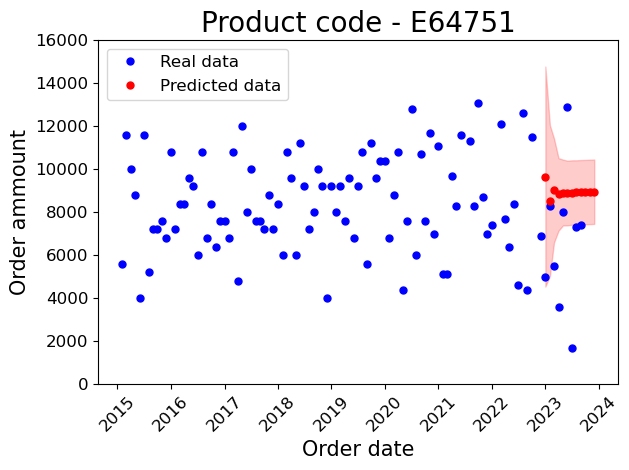

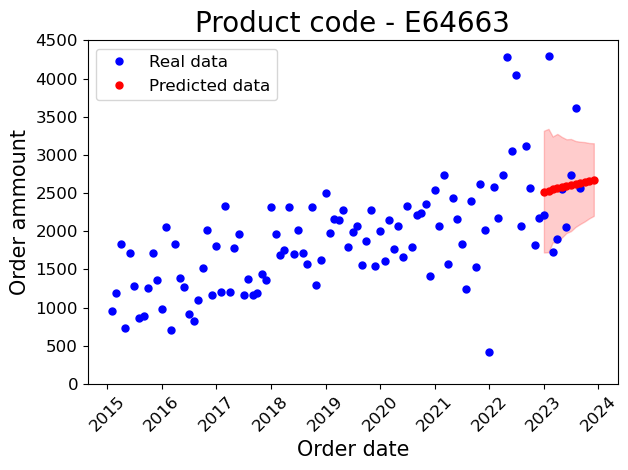

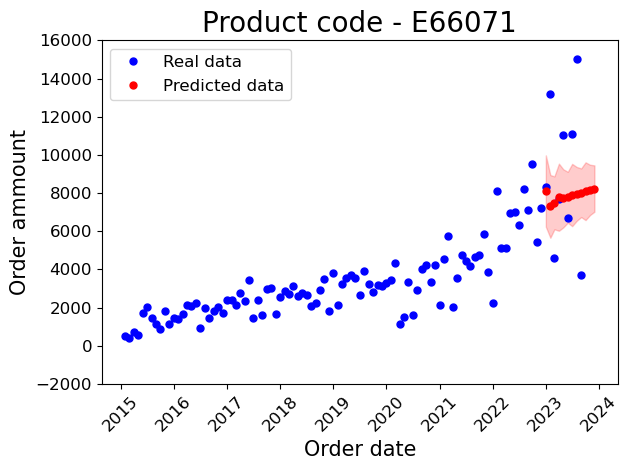

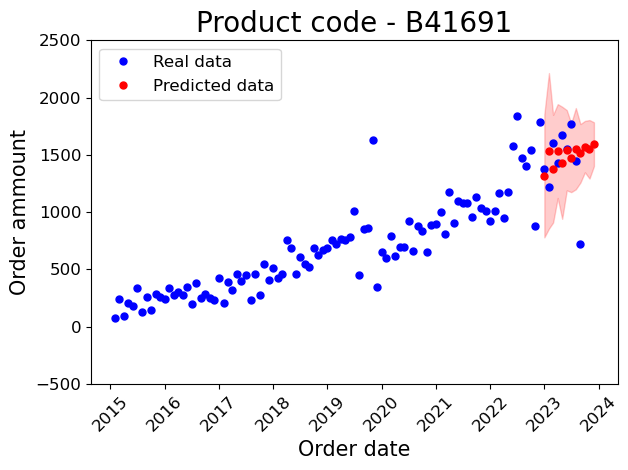

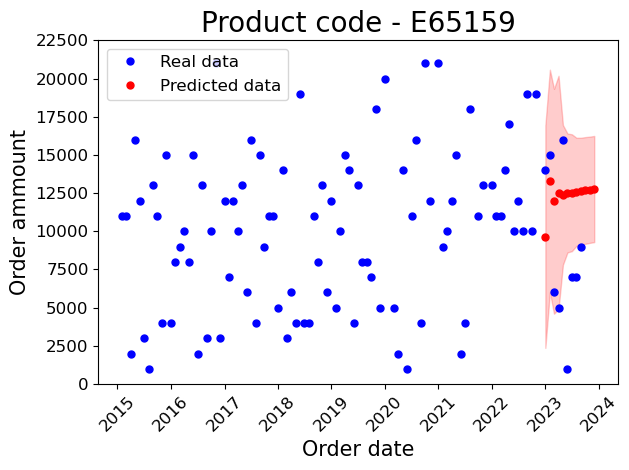

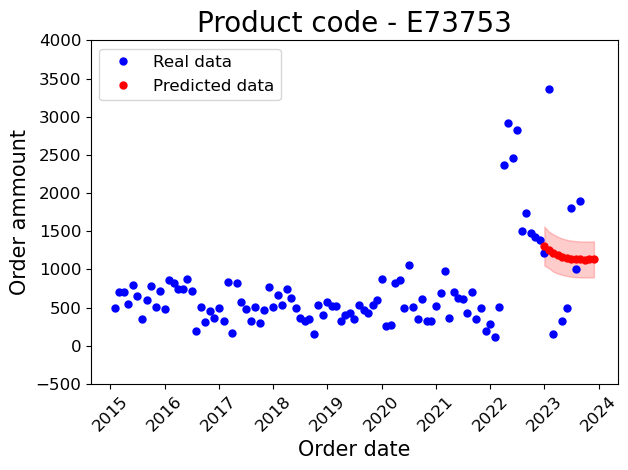

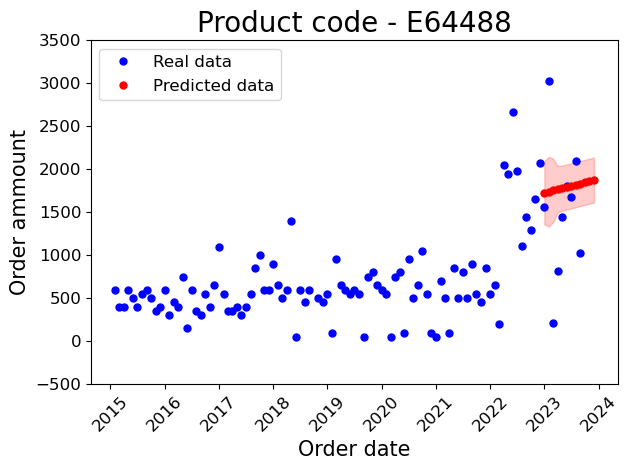

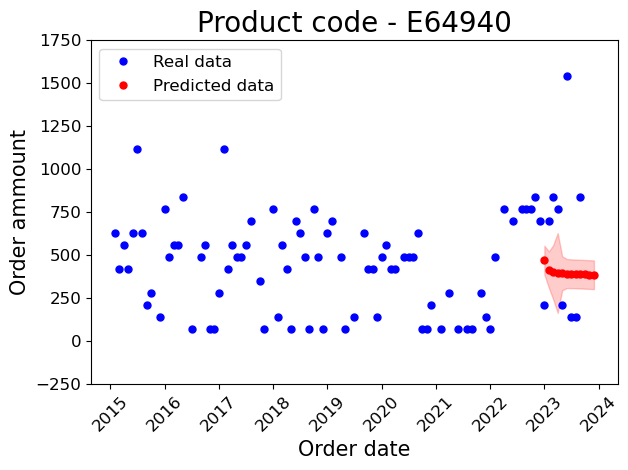

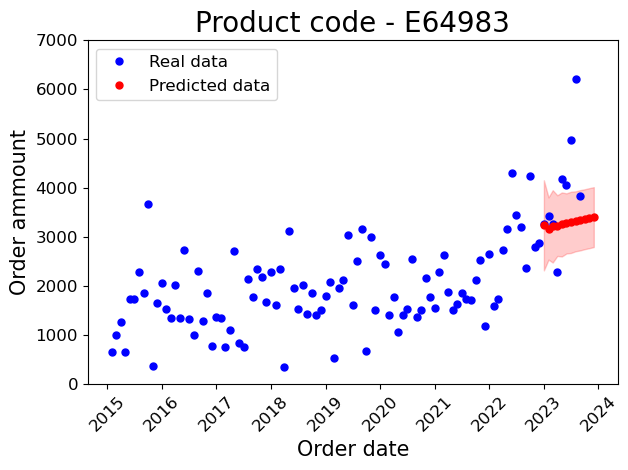

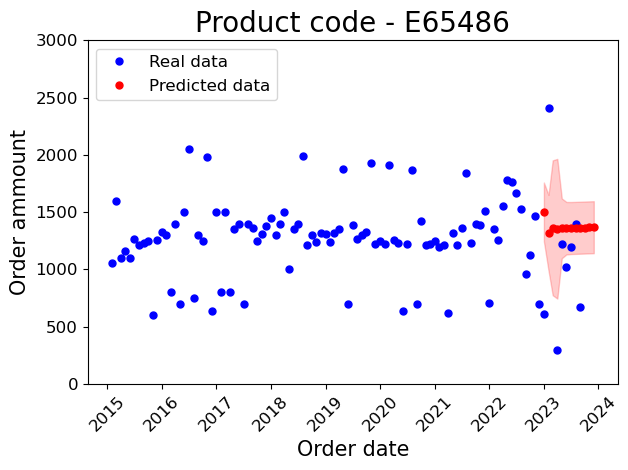

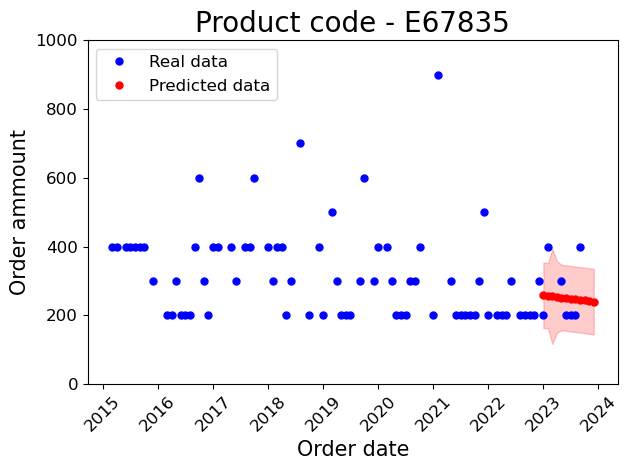

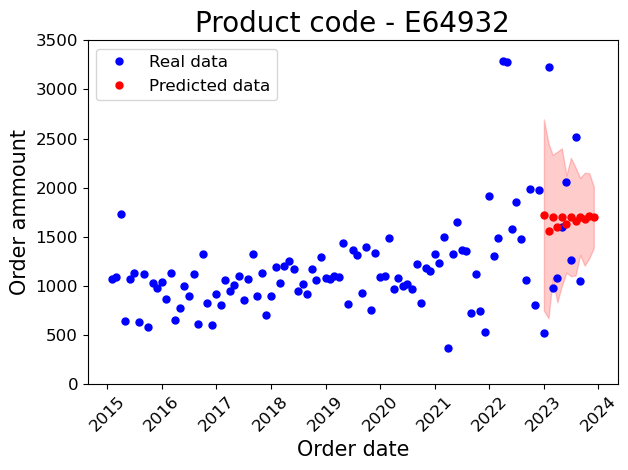

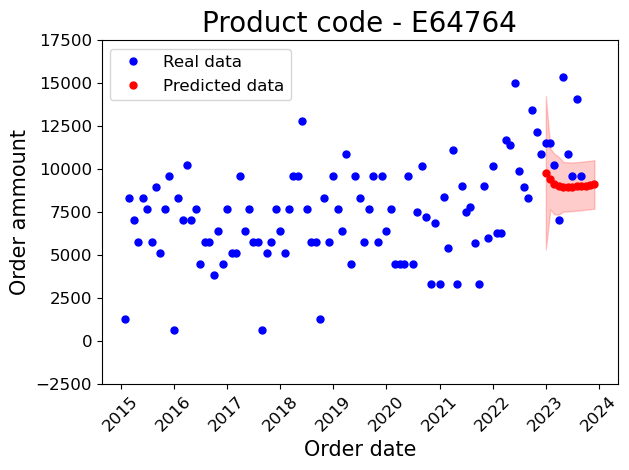

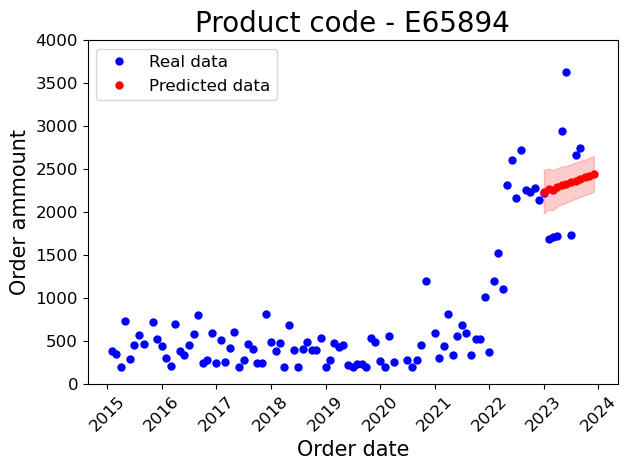

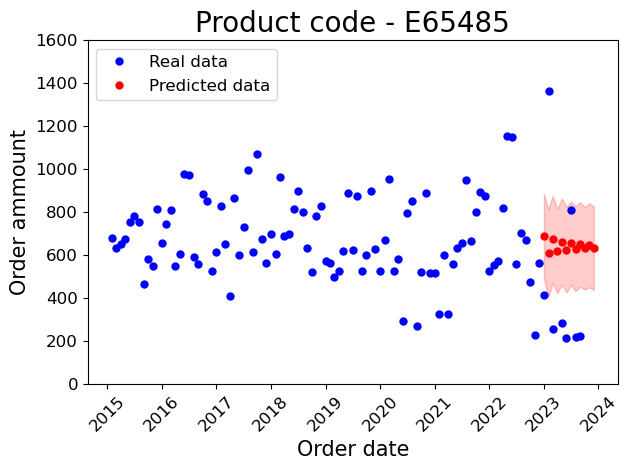

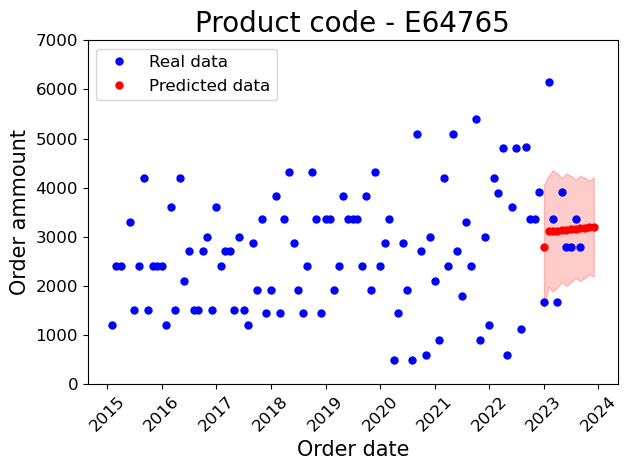

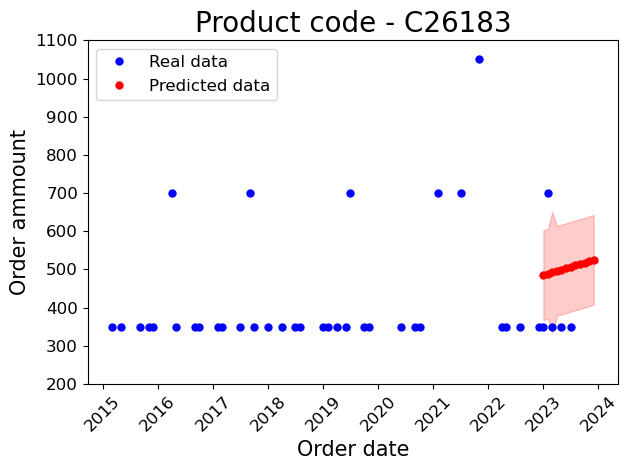

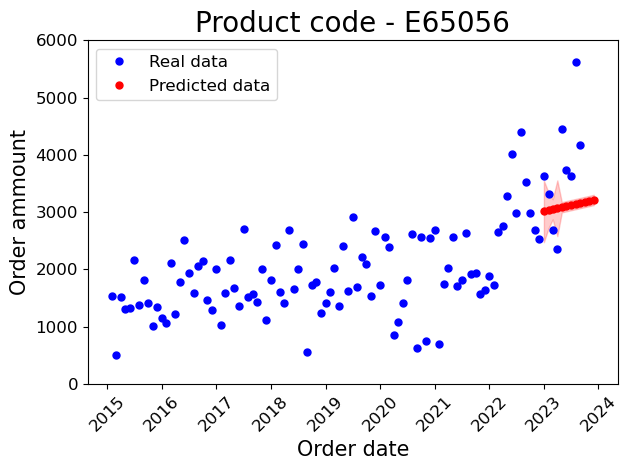

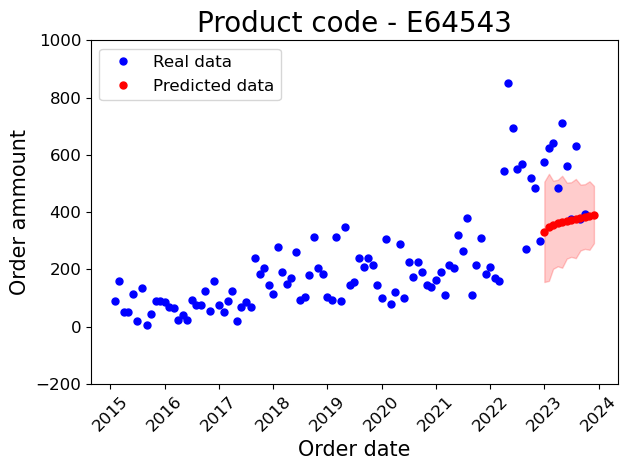

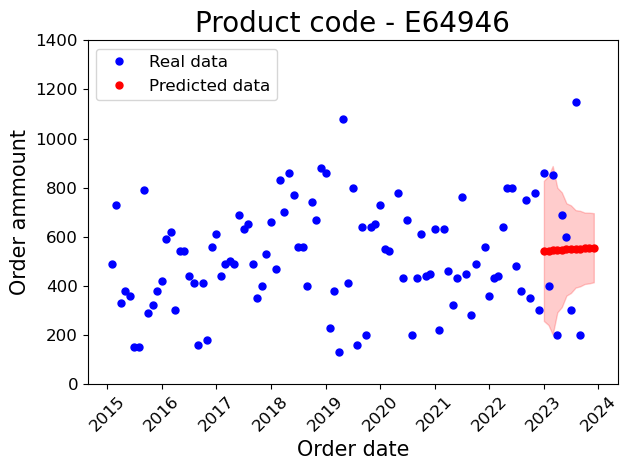

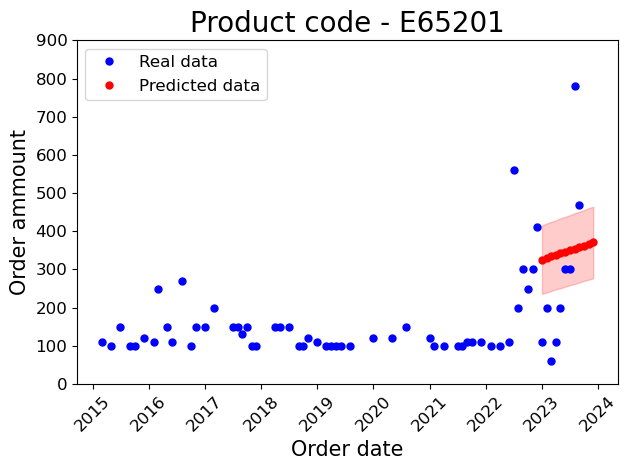

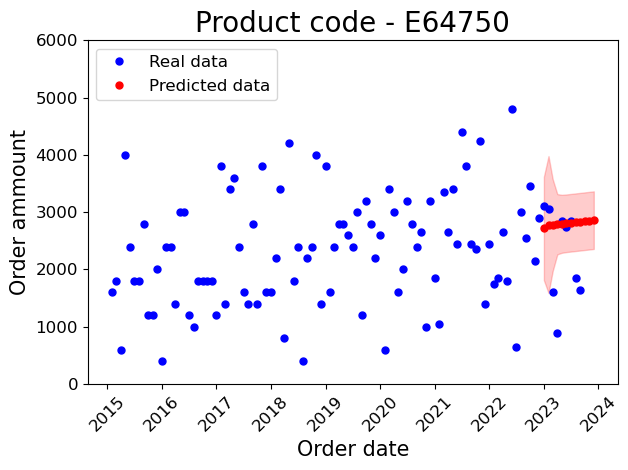

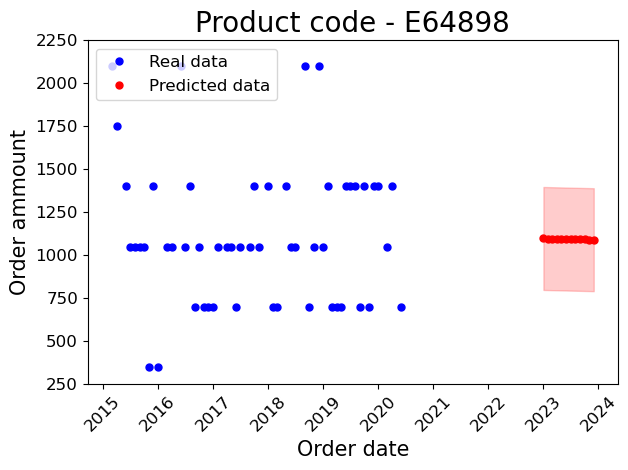

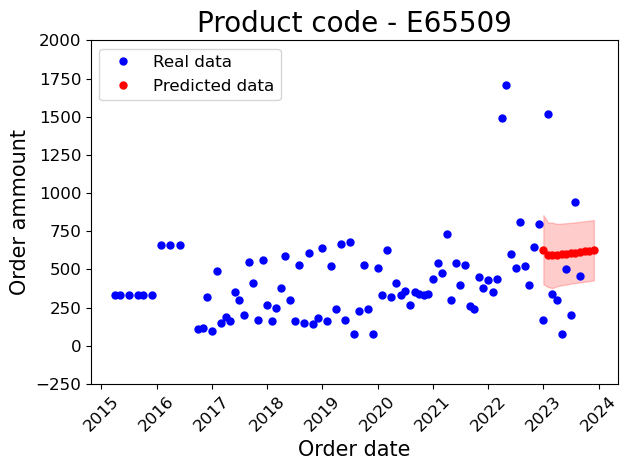

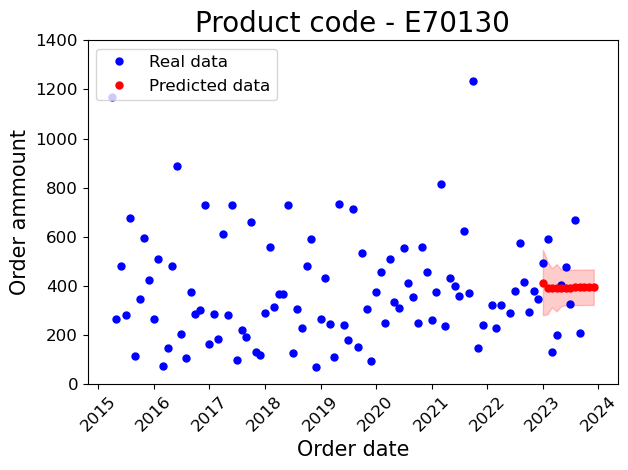

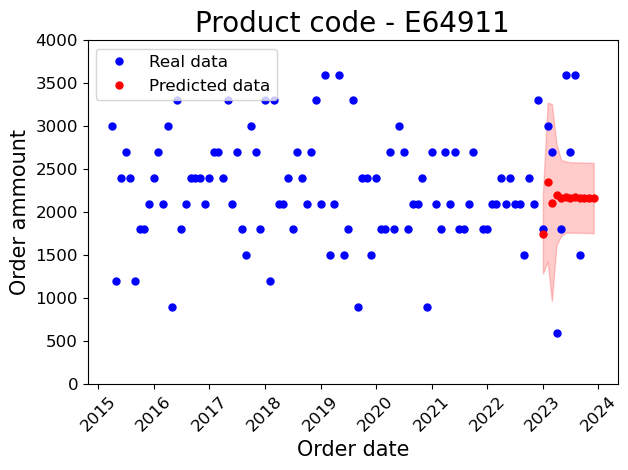

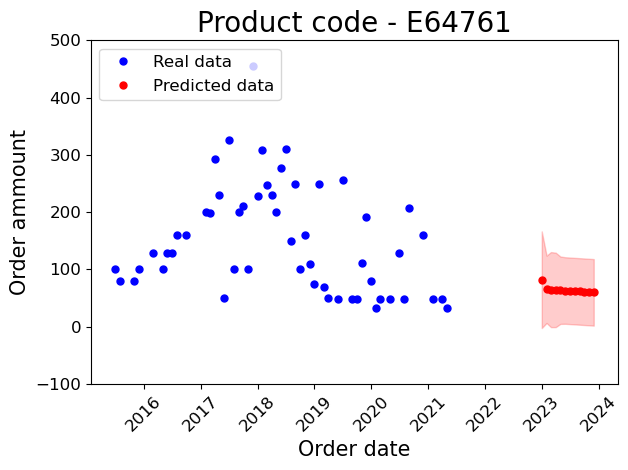

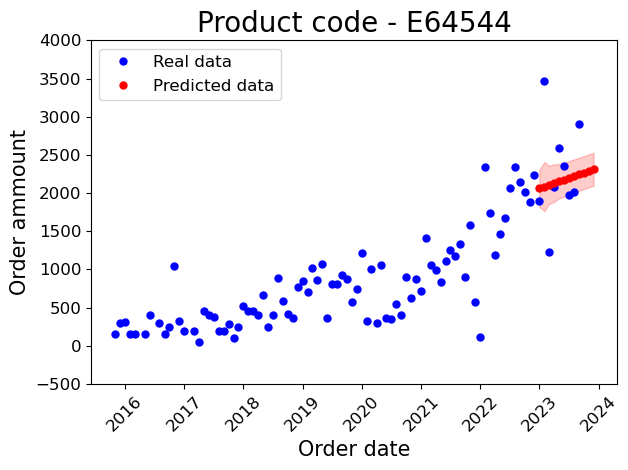

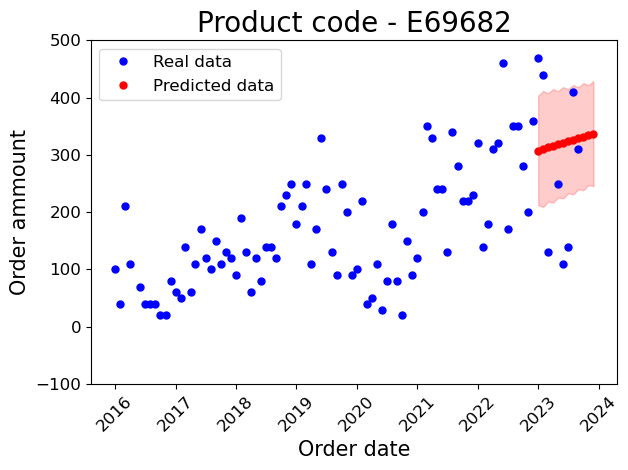

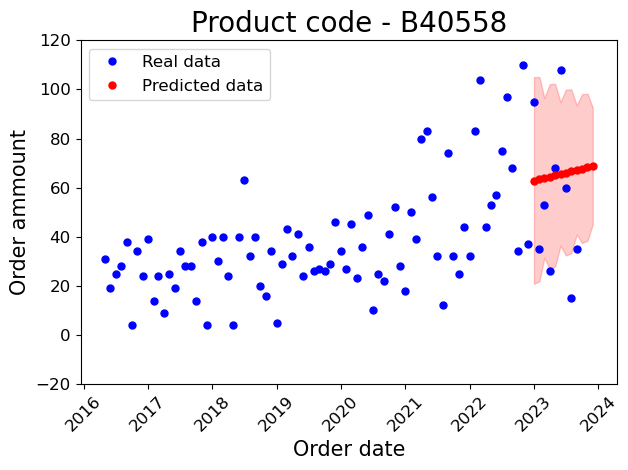

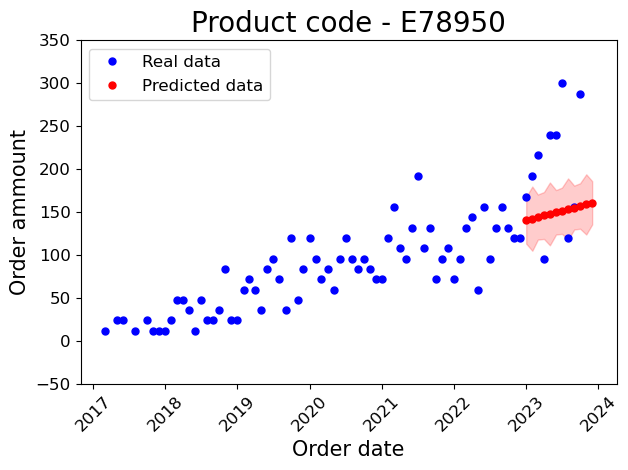

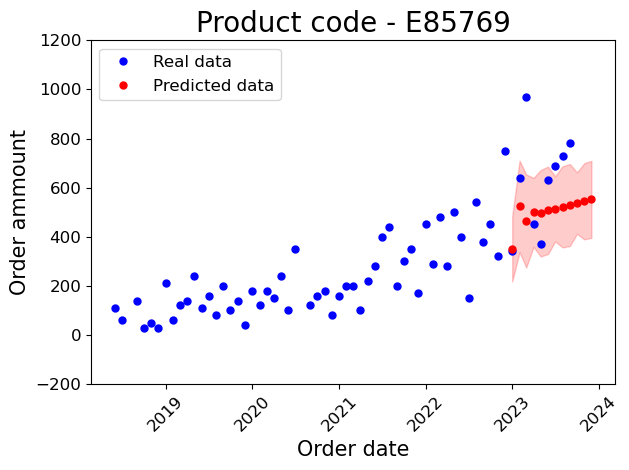

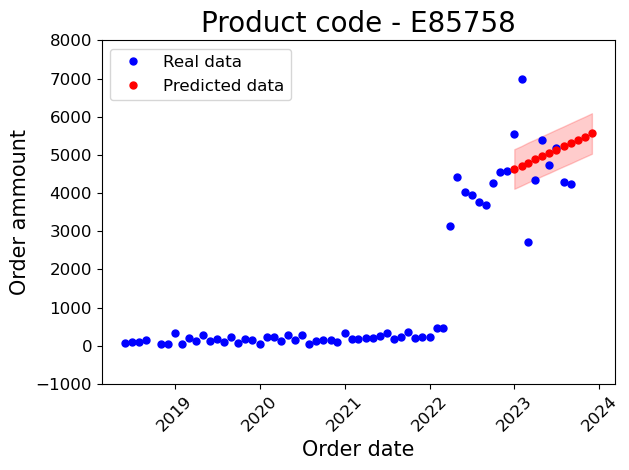

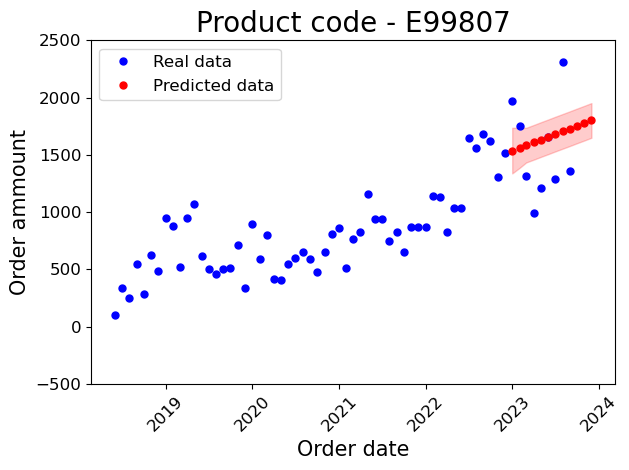

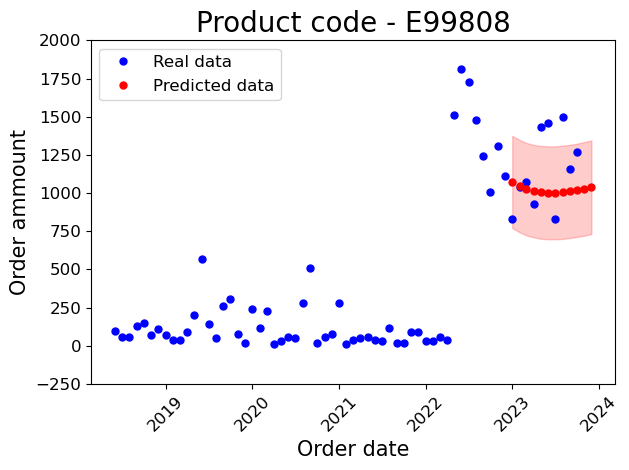

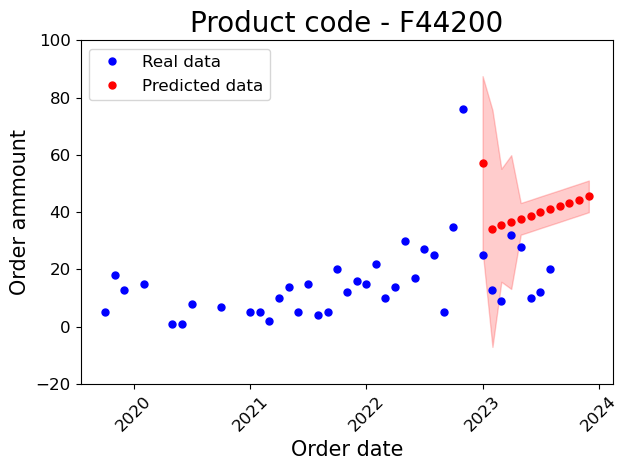

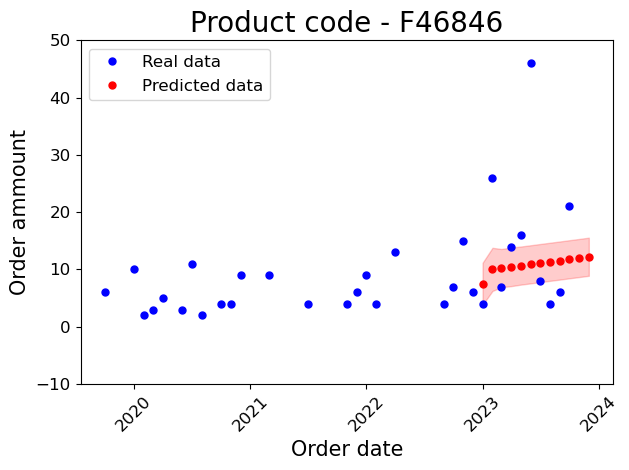

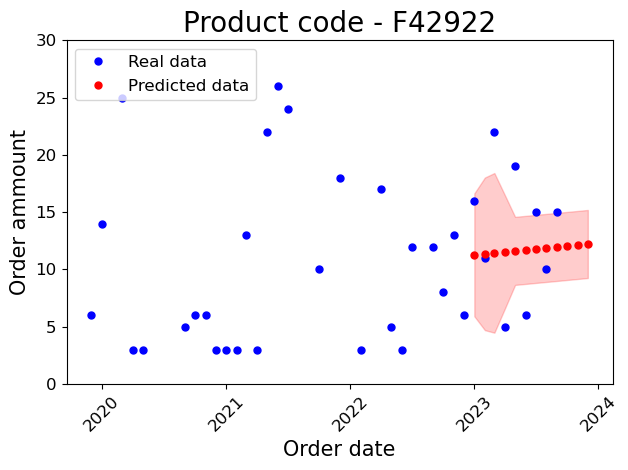

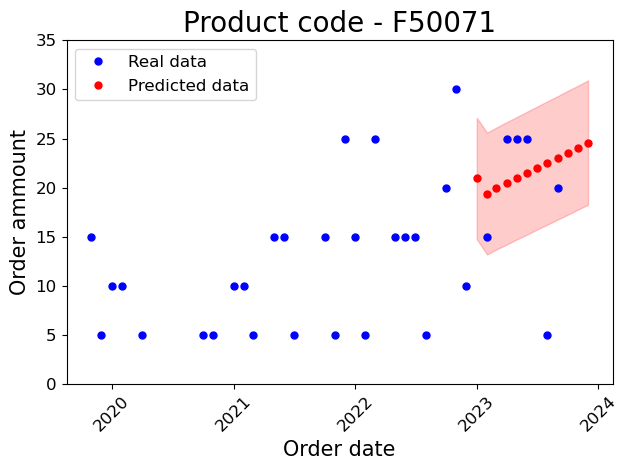

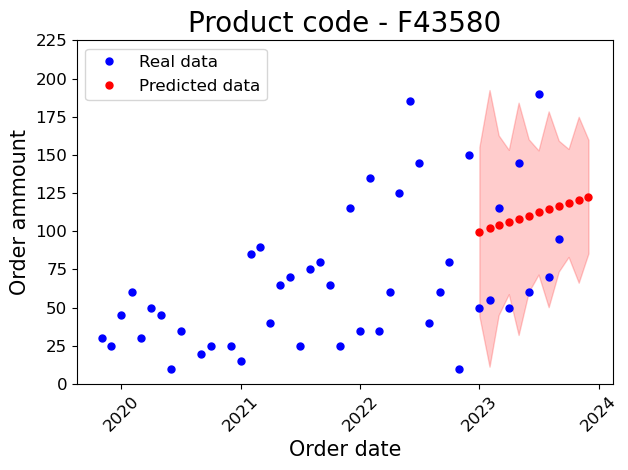

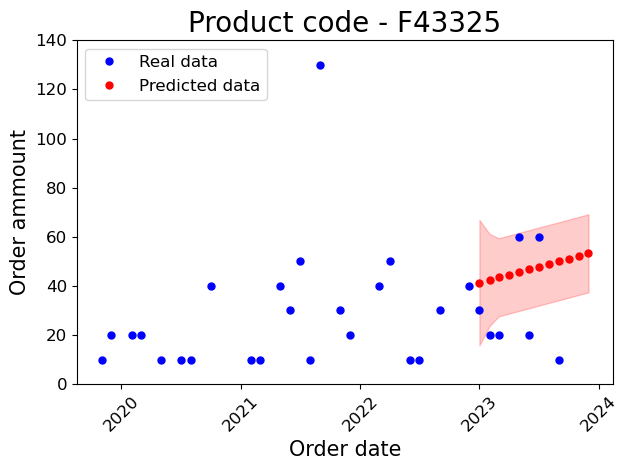

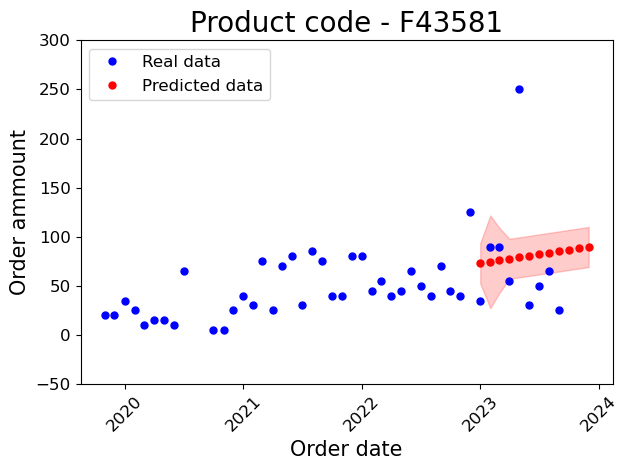

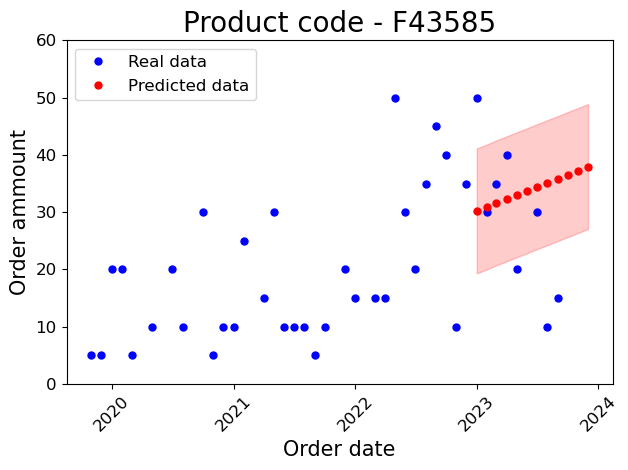

In [43]:
for codigo_fijado in Lista_codigo:
    
    #DATA-MODEL
    plot_df = Final_Data[Final_Data["CODIGO"] == codigo_fijado]
    plot_df = plot_df.dropna(subset=['NUMEROCOMPRAS']) 
    plot_df = plot_df.reset_index(drop=True) # Resetting the indices using df.reset_index()
    plot_df["MES"] = pd.to_datetime(plot_df["MES"], format = '%Y-%m-%d')
    plot_df = plot_df[plot_df["MES"].dt.strftime('%Y') == "2023"]

    #DATA-REAL
    mensual_hospital_codigo = pd.DataFrame()
    mensual_hospital_codigo["MES"] = ""
    MES = []
    mensual_hospital_codigo["NUMEROCOMPRAS"] = ""
    NUMEROCOMPRAS = []

    #df_hospital_codigo = df_2[(df_2["CODIGO"] == codigo_fijado) & (df_2["HOSPITAL"] == hospital_fijado)]
    df_hospital_codigo = df_2[(df_2["CODIGO"] == codigo_fijado) & (df_2["REGION"] == 0)]

    fechas_hospital_codigo = df_hospital_codigo["FECHAPEDIDO"]
    fechas_hospital_codigo = fechas_hospital_codigo.dt.strftime('%Y-%m').unique()
    fechas_hospital_codigo = np.delete(fechas_hospital_codigo,0)
    fechas_hospital_codigo = np.delete(fechas_hospital_codigo,len(fechas_hospital_codigo)-1)

    for fecha_i in fechas_hospital_codigo:
        MES.append(fecha_i)
        NUMEROCOMPRAS.append(sum(df_hospital_codigo[df_hospital_codigo["FECHAPEDIDO"].dt.strftime('%Y-%m') == fecha_i]["CANTIDADCOMPRA"]))

    mensual_hospital_codigo["MES"] = MES
    mensual_hospital_codigo["MES"] = pd.to_datetime(mensual_hospital_codigo["MES"], format = '%Y-%m')
    mensual_hospital_codigo["NUMEROCOMPRAS"] = NUMEROCOMPRAS

    mensual_hospital_codigo.head(10)

    mensual_hospital_codigo = mensual_hospital_codigo.dropna(subset=['NUMEROCOMPRAS']) 
    mensual_hospital_codigo = mensual_hospital_codigo.reset_index(drop=True) # Resetting the indices using df.reset_index()
    mensual_hospital_codigo


    #FUNCION
    plot_multiscatter(2,[mensual_hospital_codigo['MES'],mensual_hospital_codigo['NUMEROCOMPRAS'],plot_df['MES'],plot_df['NUMEROCOMPRAS']],[None,None,None,plot_df['VARIANZA']],["Real data","Predicted data"],"Order date","Order ammount","Product code - "+codigo_fijado)

Vemos que hemos obtenido resultados considerablemente satisfatorios, que aun podrían ser mejor si ajustasemos la varianza del ruído blanco del modelo. Por lo tanto, podemos afirmar que el problema ya esta resutlo y la solución se encuentra guardada en Final_Data. Por ejemplo, para el producto "B41691", deberíamos realizar las siguientes compras:

In [44]:
Final_Data[Final_Data["CODIGO"] == "B41691"].tail(12)

,MES,NUMEROCOMPRAS,diferenciada,VARIANZA,CODIGO
409,2023-01-01,1317.026509,-472.973491,536.780233,B41691
410,2023-02-01,1535.505916,218.479407,678.889145,B41691
411,2023-03-01,1379.746018,-155.759898,469.868965,B41691
412,2023-04-01,1533.509449,153.763432,409.550915,B41691
413,2023-05-01,1431.274405,-102.235044,489.365026,B41691
414,2023-06-01,1540.768860,109.494455,350.210618,B41691
415,2023-07-01,1475.147504,-65.621356,300.196115,B41691
416,2023-08-01,1554.359756,79.212252,354.574352,B41691
417,2023-09-01,1513.784000,-40.575756,255.102553,B41691
418,2023-10-01,1572.281705,58.497705,224.289672,B41691


Finalmente, notamos que en función de en que situación nos encontremos, podemos comprar otro valor que se encuentre dentro de la varianza.